In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error

In [2]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.3)

# Reading FE & Label

In [3]:
fe = pd.read_csv("outputs/fe.csv")
fe.head()

,weekId,max_duration,min_duration,mean_duration,sum_duration,std_duration,max_viewCount,min_viewCount,mean_viewCount,sum_viewCount,...,max_percLike,min_percLike,mean_percLike,sum_percLike,std_percLike,max_ratioLikeComment,min_ratioLikeComment,mean_ratioLikeComment,sum_ratioLikeComment,std_ratioLikeComment
0,101,996.0,959.0,977.500000,1955.0,26.162951,726428.0,165445.0,445936.50,891873.0,...,0.096632,0.057735,0.077183,0.154367,0.027504,21.552349,6.596685,14.074517,28.149034,10.575251
1,102,862.0,618.0,753.666667,2261.0,124.275232,258275.0,72186.0,136294.00,408882.0,...,0.061713,0.040538,0.051326,0.153978,0.010594,11.115385,2.765926,8.068166,24.204497,4.608927
2,103,1660.0,417.0,1035.500000,4142.0,579.811751,1101650.0,21376.0,406366.25,1625465.0,...,0.068806,0.039016,0.049685,0.198739,0.013436,27.457688,5.413547,12.363831,49.455324,10.164699
3,104,979.0,279.0,706.250000,2825.0,300.094846,1339138.0,28117.0,374999.25,1499997.0,...,0.077672,0.037486,0.058391,0.233563,0.019818,13.068862,2.966497,7.673158,30.692632,5.341116
4,105,1954.0,390.0,997.500000,3990.0,669.611081,368889.0,32923.0,208712.00,834848.0,...,0.081081,0.034900,0.055441,0.221763,0.019091,18.799497,5.075536,10.544267,42.177069,6.164214


In [4]:
label = pd.read_csv("outputs/spy_label.csv")
label.tail()

,weekId,ratioClose
283,284,-1.891455
284,285,1.756734
285,286,0.234233
286,287,3.440237
287,288,-1.183101


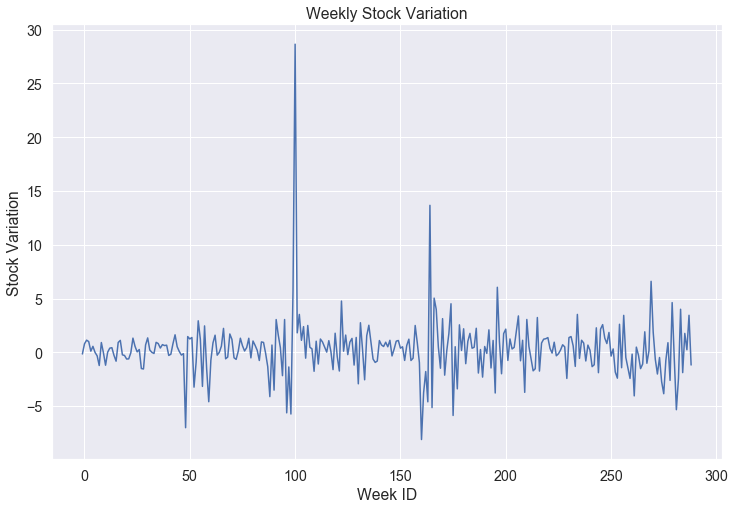

In [5]:
sns.lineplot(data = label, x = "weekId", y = "ratioClose").\
    set(title = "Weekly Stock Variation", xlabel = "Week ID", ylabel = "Stock Variation")
plt.show()

In [6]:
label = label[(np.abs(stats.zscore(label.ratioClose)) < 3)]

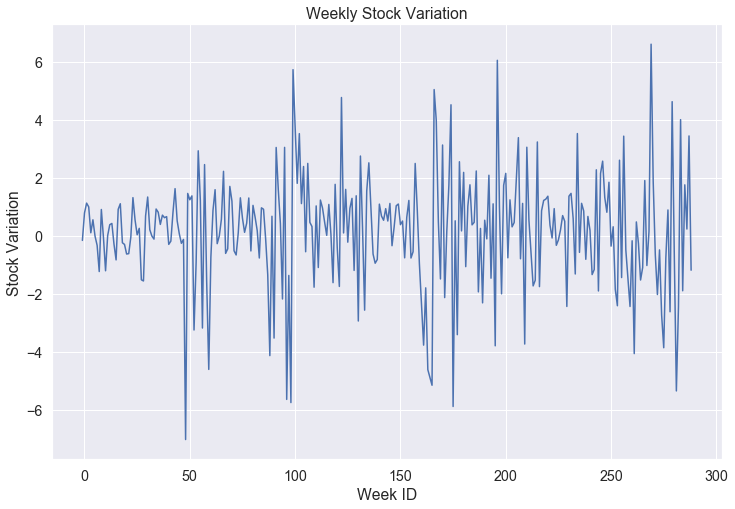

In [7]:
sns.lineplot(data = label, x = "weekId", y = "ratioClose").\
    set(title = "Weekly Stock Variation", xlabel = "Week ID", ylabel = "Stock Variation")
plt.show()

# Preparing Modeling Dataset

In [8]:
data = fe.merge(label, how = "inner")
print(data.shape)

(184, 42)


In [9]:
corr = data[[c for c in data if c != "weekId"]].corr()

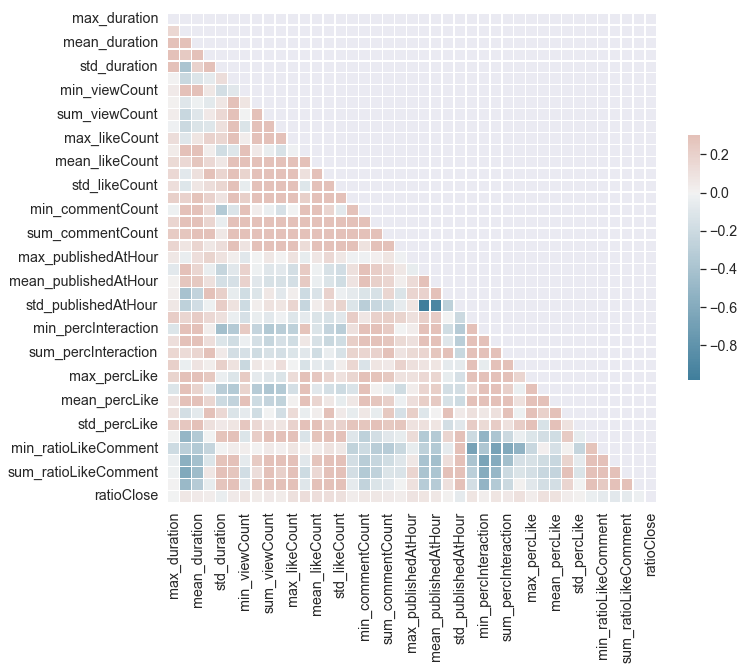

In [10]:
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# Modeling Regression

In [11]:
X = data[[c for c in data.columns if c not in ["weekId", "ratioClose"]]]
y = data[["weekId", "ratioClose"]]

scaler = StandardScaler()
scaler.fit(X)
X_scale = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scale, y, test_size = 0.3, random_state = 0)

## Ridge / Lasso / ElasticNet

1.8079772225565853


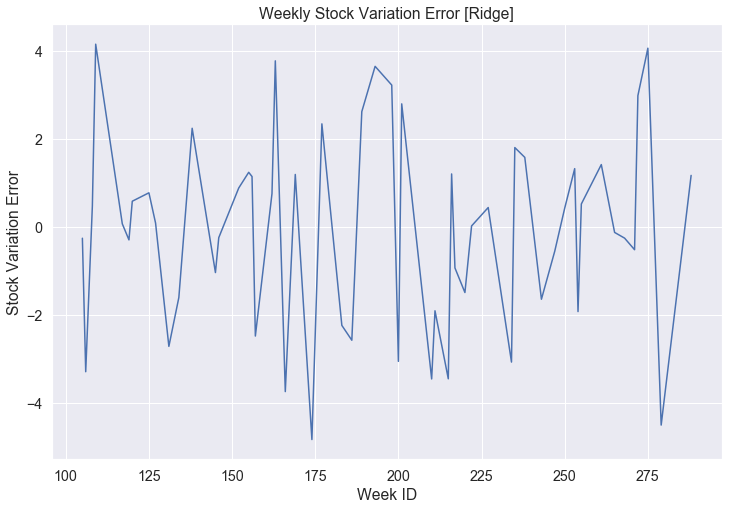

In [12]:
#reg = linear_model.Lasso(alpha=1.0)
reg = linear_model.Ridge()
#reg = linear_model.ElasticNet(random_state=0)
reg.fit(X_train, y_train.ratioClose)

results = pd.DataFrame()
results["weekId"] = y_test.weekId
results["y_test"] = y_test.ratioClose
results["y_pred"] = reg.predict(X_test)
results["diff"] = results["y_pred"] - results["y_test"]

print(mean_absolute_error(y_test.ratioClose, reg.predict(X_test)))
sns.lineplot(data = results, x = "weekId", y = "diff").\
    set(title = "Weekly Stock Variation Error [Ridge]", xlabel = "Week ID", ylabel = "Stock Variation Error")
plt.show()

## Bayesian

1.7860812048641157


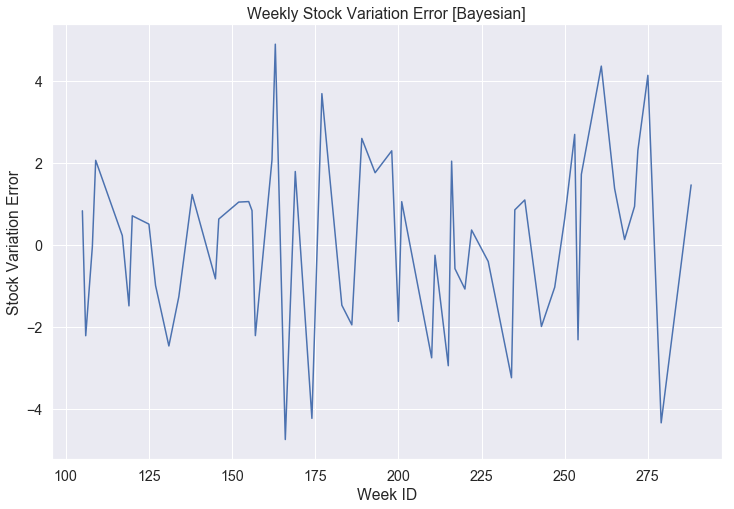

In [13]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train.ratioClose)

results = pd.DataFrame()
results["weekId"] = y_test.weekId
results["y_test"] = y_test.ratioClose
results["y_pred"] = reg.predict(X_test)
results["diff"] = results["y_pred"] - results["y_test"]

print(mean_absolute_error(y_test.ratioClose, reg.predict(X_test)))
sns.lineplot(data = results, x = "weekId", y = "diff").\
    set(title = "Weekly Stock Variation Error [Bayesian]", xlabel = "Week ID", ylabel = "Stock Variation Error")
plt.show()

## SVM

1.8331170454297818


[]

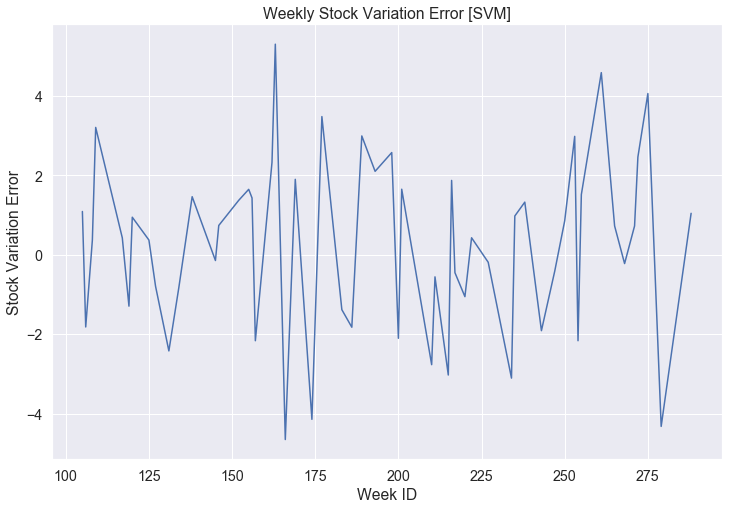

In [14]:
reg = svm.SVR(kernel='rbf')
reg.fit(X_train, y_train.ratioClose)

results = pd.DataFrame()
results["weekId"] = y_test.weekId
results["y_test"] = y_test.ratioClose
results["y_pred"] = reg.predict(X_test)
results["diff"] = results["y_pred"] - results["y_test"]

print(mean_absolute_error(y_test.ratioClose, reg.predict(X_test)))
sns.lineplot(data = results, x = "weekId", y = "diff").\
    set(title = "Weekly Stock Variation Error [SVM]", xlabel = "Week ID", ylabel = "Stock Variation Error")
plt.plot()

## Random Forest

1.7723365456097695


[]

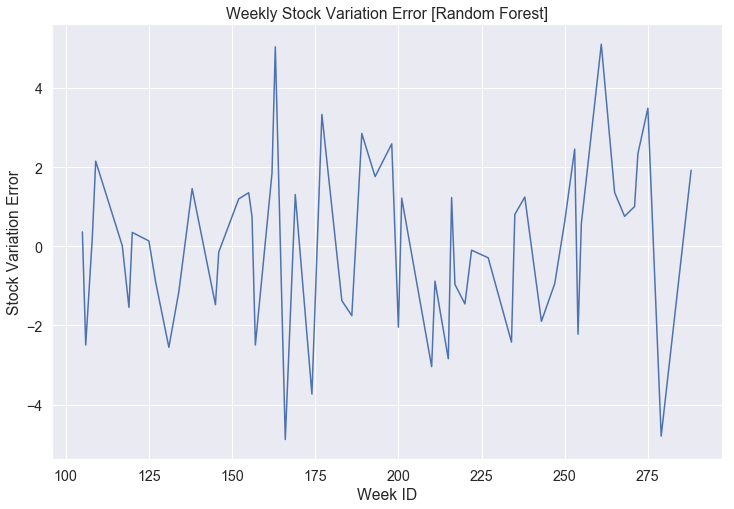

In [15]:
reg = RandomForestRegressor()
reg.fit(X_train, y_train.ratioClose)

results = pd.DataFrame()
results["weekId"] = y_test.weekId
results["y_test"] = y_test.ratioClose
results["y_pred"] = reg.predict(X_test)
results["diff"] = results["y_pred"] - results["y_test"]

print(mean_absolute_error(y_test.ratioClose, reg.predict(X_test)))
sns.lineplot(data = results, x = "weekId", y = "diff").\
    set(title = "Weekly Stock Variation Error [Random Forest]", xlabel = "Week ID", ylabel = "Stock Variation Error")
plt.plot()

## Ada Boost

1.9032013048324055


[]

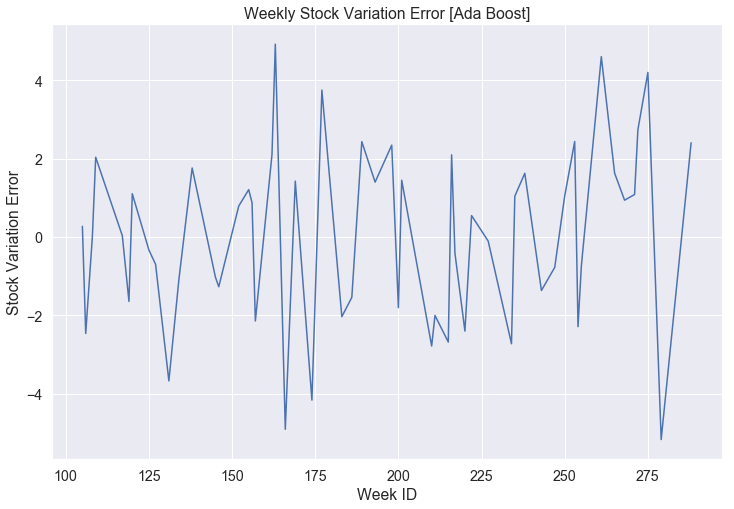

In [16]:
reg = AdaBoostRegressor()
reg.fit(X_train, y_train.ratioClose)

results = pd.DataFrame()
results["weekId"] = y_test.weekId
results["y_test"] = y_test.ratioClose
results["y_pred"] = reg.predict(X_test)
results["diff"] = results["y_pred"] - results["y_test"]

print(mean_absolute_error(y_test.ratioClose, reg.predict(X_test)))
sns.lineplot(data = results, x = "weekId", y = "diff").\
    set(title = "Weekly Stock Variation Error [Ada Boost]", xlabel = "Week ID", ylabel = "Stock Variation Error")
plt.plot()

## Multi-layer Perceptron

2.302309837319566


[]

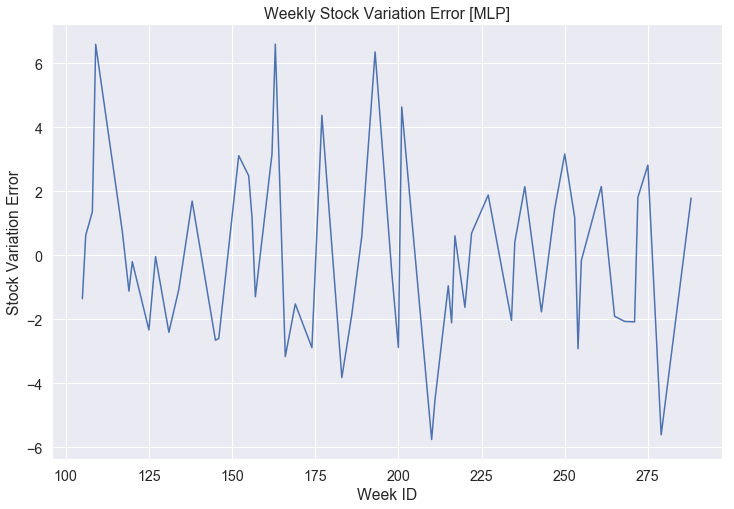

In [17]:
reg = MLPRegressor(random_state=0, max_iter=1000)
reg.fit(X_train, y_train.ratioClose)

results = pd.DataFrame()
results["weekId"] = y_test.weekId
results["y_test"] = y_test.ratioClose
results["y_pred"] = reg.predict(X_test)
results["diff"] = results["y_pred"] - results["y_test"]

print(mean_absolute_error(y_test.ratioClose, reg.predict(X_test)))
sns.lineplot(data = results, x = "weekId", y = "diff").\
    set(title = "Weekly Stock Variation Error [MLP]", xlabel = "Week ID", ylabel = "Stock Variation Error")
plt.plot()

# Final Comments

At this point, are clear 2 statements:
- The correlation between the created features based on YouTube stats is low.
- Were not tested different hyperparams into the models, however, the decission was taken based on the similarity of the default results.

So, we are going to evaluate the chances of creating a classification model.